<a href="https://colab.research.google.com/github/mvgarcia/Reto-WJ/blob/main/preparacion_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Carga de los datos y las librerias

Importamos drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos de las librerías necesarias

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
from shutil import copyfile
from tqdm.notebook import tqdm
import urllib.request
from PIL import Image
pd.options.mode.chained_assignment = None  

Leemos los datos y filtramos según las variables que vamos a utilizar para la clasificación:

*   **Percepción** de la persona respecto a la imagen
*   **Sentiment_value**, que cuantiza la intensidad y confiabilidad de la percepción



In [ ]:
df = pd.read_csv('https://query.data.world/s/q2gk5jdoaxu7atza6zlejks763uqwi')
df.drop('_unit_state', axis=1, inplace=True)
df.drop('_golden', axis=1, inplace=True)
df.drop('_trusted_judgments', axis=1, inplace=True)
df.drop('_last_judgment_at', axis=1, inplace=True)
df.drop('which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold', axis=1, inplace=True)
df.drop('which_of_these_sentiment_scores_does_the_above_image_fit_into_best_gold_reason', axis=1, inplace=True)
df.reset_index(inplace=True)

df['sentiment'] = [0]*len(df)
columns = ['name', 'id', 'perception', 'sentiment_value', 'img_url', 'sentiment']
df.columns = columns

df['name'] = ['{}.png'.format(x) for x in df['name']]
df.set_index(['name'], inplace=True)

Descargamos todas las imágenes y las guardamos en una carpeta. El try-except está hecho debido a que algunos links estaban caídos.

In [ ]:
urls=df['img_url']

for i in tqdm(range(len(urls))):
    try:
        urllib.request.urlretrieve(urls[i],"/content/drive/MyDrive/Reto/dataset/{}/{}.png".format(df['sentiment'][i],i))
    except:
        pass

Con todas las imágenes que pudieron descargarse, las filtramos del DataFrame original y descartamos las filas pertenecientes a los datos que no consideraremos.

In [ ]:
imgs = []
for i in range(5): 
  imgs += glob.glob("/content/drive/MyDrive/Reto/dataset/{}/*.png".format(i))

imgs = [x[38:] for x in imgs]
mask_imgs = [x in imgs for x in np.array(df.index)]

columns = ['id', 'perception', 'sentiment_value', 'img_url', 'sentiment']
df = df[columns][mask_imgs]
df

,id,perception,sentiment_value,img_url,sentiment
name,,,,,
0.png,694550568,Positive,0.6395,http://farm1.staticflickr.com/20/71235476_3103...,0
1.png,694550569,Positive,0.6458,http://farm4.staticflickr.com/3096/2584485524_...,0
2.png,694550570,Negative,0.8420,http://farm3.staticflickr.com/2880/11733997835...,0
3.png,694550571,Positive,0.7216,http://farm4.staticflickr.com/3022/2286937150_...,0
4.png,694550572,Positive,0.8801,http://farm1.staticflickr.com/163/357381033_d0...,0
...,...,...,...,...,...
15604.png,694566359,Positive,1.0000,http://farm3.static.flickr.com/2079/1564949179...,0
15607.png,694566362,Positive,1.0000,http://farm1.static.flickr.com/81/265693044_bc...,0
15608.png,694566363,Positive,0.6705,http://farm3.static.flickr.com/2198/1572103607...,0


Imprimimos un histograma que muestra la distribución de la percepción

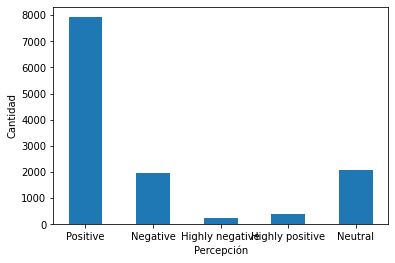

In [ ]:
plt.hist(df['perception'], align='mid', rwidth=0.5, bins=np.arange(6)-0.5, label='Percepciones')
plt.xlabel('Percepción')
plt.ylabel('Cantidad')
plt.show()

##Creación de las clases

Definimos los seis sentimientos (clases) y los rangos del valor de sentiment_value (confidencia) sobre los cuales filtraremos los datos:

* 0: **Miedo** - Highly negative y Negative (hasta 0.6686 en confidence).
* 1: **Tristeza** - Negative (desde 0.6686 en confidence).
* 2: **Neutro** - Neutral.
* 3: **Bienestar** - Positive (hasta 0.667 en confidence).
* 4: **Alegría** - Positive (desde 0.667 hasta 1 en confidence).
* 5: **Euforia** - Highly positive y Positive (con confidencia de 1).

Con estas máscaras, filtramos los datos y escribimos el resultado en la columna _sentiment_. Finalmente, imprimimos la cantidad de datos en cada clase realizamos un histograma.

Cantidad miedo:  	1101
Cantidad tristeza: 	1106
Cantidad neutro: 	2068
Cantidad bienestar:    	2329
Cantidad alegria: 	2315
Cantidad euforia: 	3677



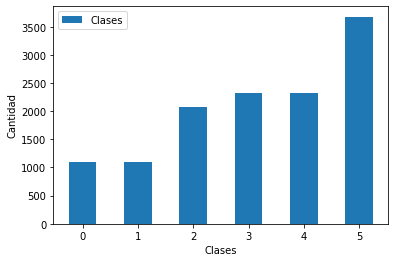

In [ ]:
#Máscaras a utilizar

dif_miedo_tristeza = 0.6686
dif_bienestar_alegria = 0.667
dif_alegria_euforia = 1

mask_miedo = (df['perception'] == 'Highly negative') | ((df['perception'] == 'Negative') & (df['sentiment_value'] >= dif_miedo_tristeza))
mask_tristeza = (df['perception'] == 'Negative') & (df['sentiment_value'] < dif_miedo_tristeza)
mask_neutro = (df['perception'] == 'Neutral') 
mask_bienestar = (df['perception'] == 'Positive') & (df['sentiment_value'] < dif_bienestar_alegria)
mask_alegria = (df['perception'] == 'Positive') & (df['sentiment_value'] >= dif_bienestar_alegria) & (df['sentiment_value'] < dif_alegria_euforia)
mask_euforia = (df['perception'] == 'Highly positive') | ((df['perception'] == 'Positive') & (df['sentiment_value'] >= dif_alegria_euforia))

#Definimos las clases en la columna sentiment

df['sentiment'][mask_miedo] = 0
df['sentiment'][mask_tristeza] = 1
df['sentiment'][mask_neutro] = 2
df['sentiment'][mask_bienestar] = 3
df['sentiment'][mask_alegria] = 4
df['sentiment'][mask_euforia] = 5

print('Cantidad miedo:  \t{}'.format(len((df['sentiment_value'][mask_miedo]))))
print('Cantidad tristeza: \t{}'.format(len((df['sentiment_value'][mask_tristeza]))))
print('Cantidad neutro: \t{}'.format(len((df['sentiment_value'][mask_neutro]))))
print('Cantidad bienestar:    \t{}'.format(len((df['sentiment_value'][mask_bienestar]))))
print('Cantidad alegria: \t{}'.format(len((df['sentiment_value'][mask_alegria]))))
print('Cantidad euforia: \t{}'.format(len((df['sentiment_value'][mask_euforia]))))
print('')

plt.hist(df['sentiment'], align='mid', rwidth=0.5, bins=np.arange(7)-0.5, label='Clases') 
plt.legend()
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.show()

##Filtrado de las imágenes según Train o Test

Con estas máscaras ya creadas, copiamos y pegamos un 90% de las imágenes en carpetas correspondientes según su clase pertenecientes a la carpeta de entrenamiento, el otro 10% lo usaremos en las de testeo.

In [ ]:
imgs = []
for i in range(5): 
  imgs += glob.glob("/content/drive/MyDrive/Reto/dataset/{}/*.png".format(i))

path = '/content/drive/MyDrive/Reto/data/'

p_train = 0.9

dicc_train = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
len_list = [len((df['sentiment_value'][mask_miedo])),
           len((df['sentiment_value'][mask_tristeza])),
           len((df['sentiment_value'][mask_neutro])),
           len((df['sentiment_value'][mask_bienestar])),
           len((df['sentiment_value'][mask_alegria])),
           len((df['sentiment_value'][mask_euforia]))]
          
for i in range(len(imgs)):
  num = imgs[i][38:]
  sentiment = df.loc[num]['sentiment']
 
  if dicc_train[str(sentiment)]<p_train*len_list[sentiment]:
    copyfile(imgs[i], '{}train/{}/{}'.format(path, sentiment, num))
    dicc_train[str(sentiment)] = dicc_train[str(sentiment)] + 1
    print('train{}'.format(imgs[i][35:]), 'train/{}/{}'.format(sentiment, num))
  else:
    copyfile(imgs[i], '{}test/{}/{}'.format(path, sentiment, num))
    print('test{}'.format(imgs[i][35:]), 'test/{}/{}'.format(sentiment, num))

Y probamos que la suma de datos de entrenamiento y testeo sea la misma que el total anteriormente clasificado

In [ ]:
print('Miedo train: \t\t{} \t\t Miedo test: \t\t{} \t\t Total: {}'.format(len(glob.glob('{}train/0/*.png'.format(path))), len(glob.glob('{}test/0/*.png'.format(path))),
                                                                      len(glob.glob('{}train/0/*.png'.format(path))) + len(glob.glob('{}test/0/*.png'.format(path)))))
print('Tristeza train: \t{} \t\t Tristeza test: \t{} \t\t Total: {}'.format(len(glob.glob('{}train/1/*.png'.format(path))), len(glob.glob('{}test/1/*.png'.format(path))),
                                                                      len(glob.glob('{}train/1/*.png'.format(path))) + len(glob.glob('{}test/1/*.png'.format(path)))))
print('Neutro train: \t\t{} \t\t Neutro test: \t\t{} \t\t Total: {}'.format(len(glob.glob('{}train/2/*.png'.format(path))), len(glob.glob('{}test/2/*.png'.format(path))),
                                                                      len(glob.glob('{}train/2/*.png'.format(path))) + len(glob.glob('{}test/2/*.png'.format(path)))))
print('Bienestar train: \t{} \t\t Bienestar test: \t{} \t\t Total: {}'.format(len(glob.glob('{}train/3/*.png'.format(path))), len(glob.glob('{}test/3/*.png'.format(path))),
                                                                      len(glob.glob('{}train/3/*.png'.format(path))) + len(glob.glob('{}test/3/*.png'.format(path)))))
print('Alegría train: \t\t{} \t\t Alegría test: \t\t{} \t\t Total: {}'.format(len(glob.glob('{}train/4/*.png'.format(path))), len(glob.glob('{}test/4/*.png'.format(path))),
                                                                      len(glob.glob('{}train/4/*.png'.format(path))) + len(glob.glob('{}test/4/*.png'.format(path)))))
print('Euforia train: \t\t{} \t\t Euforia test: \t\t{} \t\t Total: {}'.format(len(glob.glob('{}train/5/*.png'.format(path))), len(glob.glob('{}test/5/*.png'.format(path))),
                                                                      len(glob.glob('{}train/5/*.png'.format(path))) + len(glob.glob('{}test/5/*.png'.format(path)))))

Miedo train: 		991 		 Miedo test: 		110 		 Total: 1101
Tristeza train: 	996 		 Tristeza test: 	110 		 Total: 1106
Neutro train: 		1862 		 Neutro test: 		206 		 Total: 2068
Bienestar train: 	2097 		 Bienestar test: 	232 		 Total: 2329
Alegría train: 		2084 		 Alegría test: 		231 		 Total: 2315
Euforia train: 		3310 		 Euforia test: 		367 		 Total: 3677
